# Application of `GSPICE` to denali SV3 dataset

In this notebook, we explore $r$-band spectra of stars in *denali* dataset. We apply `gspice` routine on it.

In [1]:
import numpy as np
from scipy.signal import medfilt
from astropy.io import fits

import sys
sys.path.insert(1, '../python/')
from gspice import *

import matplotlib.pyplot as plt
plt.style.use("ggplot")

from time import time
from tqdm import tqdm 

In [2]:
starfits = fits.open("/global/cfs/projectdirs/desi/users/dfink/stars-denali-r.fits")

In [3]:
starwave = np.float64(starfits[1].data['WAVE']) #wavelength array
starflux = np.float64(starfits[1].data['SPEC']) #flux array
starivar = np.float64(starfits[1].data['IVAR']) #ivar array; add small value to avoid division by 0
#starflux_g = np.float64(starfits[1].data['FLUX_G']) #g-band flux
#starfiberflux_g = np.float64(starfits[1].data['FIBERFLUX_G']) #fiber flux
starsnr_r = np.float64(starfits[1].data['RED_SNR'])

In [4]:
starwave[0].min()

5760.0

In [5]:
starwave[0].max()

7620.0

# Preprocessing
We need to preprocess the data adequately. We apply the following steps sequentially:
- continuum normalize
- scale
- mean subtract

## Remove bad spectra

First we ignore any stars that have more than $50\%$ pixels with $\infty$ variance or stars with more than $50\%$ pixels having $0$ value in flux. 

### Identify pixels with bad flux

Number of stars with bad data: 190


(array([5.500e+01, 0.000e+00, 0.000e+00, 1.000e+00, 1.340e+02, 4.380e+02,
        2.900e+02, 2.990e+02, 3.280e+02, 9.568e+04]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

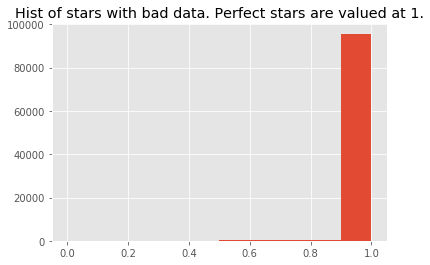

In [4]:
tmp = np.copy(starflux)

#idenfity bad pixels 
tmprange = np.arange(tmp.shape[0])
badFlux_idx = tmprange[np.sum(tmp > 0, axis = 1)/len(tmp[0]) < 0.5]
print(f"Number of stars with bad data: {np.sum(len(badFlux_idx))}")

plt.title('Hist of stars with bad data. Perfect stars are valued at 1.')
plt.hist(np.sum(tmp > 0, axis = 1)/len(tmp[0]))

### Identify pixels with bad ivar

Number of stars with bad ivar: 1020


(array([1.0200e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 1.7000e+01, 9.6186e+04]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

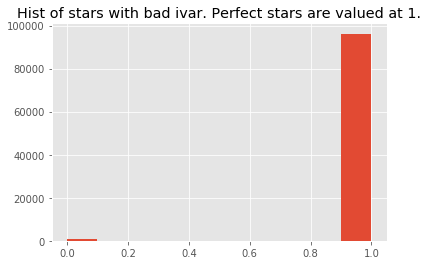

In [5]:
tmp = np.copy(starivar)

#idenfity bad pixels 
tmprange = np.arange(tmp.shape[0])
badIvar_idx = tmprange[np.sum(tmp > 0, axis = 1)/len(tmp[0]) < 0.5]
print(f"Number of stars with bad ivar: {np.sum(len(badIvar_idx))}")


plt.title('Hist of stars with bad ivar. Perfect stars are valued at 1.')
plt.hist(np.sum(tmp > 0, axis = 1)/len(tmp[0]))

### Concatenate and remove bad stars

In [6]:
idx_bad = np.union1d(badFlux_idx, badIvar_idx)
len(idx_bad)

1139

In [7]:
#WARNING RUN ONLY ONCE OTHERWISE WILL REMOVE GOOD STARS
starwave = np.delete(starwave, idx_bad, axis = 0)
starflux = np.delete(starflux, idx_bad, axis = 0)
starivar = np.delete(starivar, idx_bad, axis = 0)
#starflux_g = np.delete(starflux_g, idx_bad, axis = 0)
#starfiberflux_g = np.delete(starfiberflux_g, idx_bad, axis = 0)
starsnr_r = np.delete(starsnr_r, idx_bad, axis = 0)

#ignore extremities
padding = 50
starwave = starwave[padding:-padding]
starflux = starflux[padding:-padding]
starivar = starivar[padding:-padding]

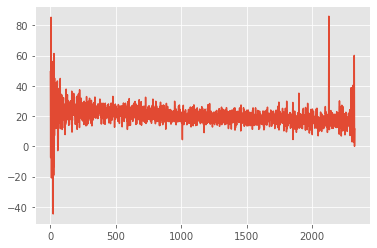

In [19]:
plt.plot(starflux[62771])

In [18]:
starflux[10][starflux[10] < 0].size/starflux[10].size*100

0.7308684436801376

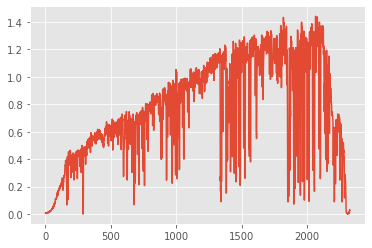

In [12]:
plt.plot(starivar[10])

def continuum_normalize(wave, flux, flux_weight, med_filt_size = 5, D = 2):
    """
    Applies median filter to 1D spectrum and returns continuum
    normalized spectrum by fitting polynomial of order D.
    
    Parameters
    ----------
    wave : 1D numpy array, size M
        wavelength grid for the spectrum
    flux : 1D numpy array, size M
        flux grid for the spectrum
    weight : 1D numpy array, size M
        weight grid for the spectrum, pass 1/sigma for Gaussian 
        uncertainties
    med_filt_size : odd number
        kernel size for median filtering ~flux~ object
    D : number
        order of polynomial fit
        
    Returns
    -------
    flux_normalized : 1D numpy array, size M
        normalized flux grid for the spectrum
    """
    
    flux_filtered = medfilt(flux, kernel_size=med_filt_size)
    a, b, c = np.polyfit(x = wave, y = flux_filtered, deg = D, w = flux_weight)
    
    flux_fitted = a * wave**2 + b * wave + c
    
    flux_normalized = flux/(flux_fitted)
    
    return flux_fitted, flux_normalized## Functions to preprocess dataset

In [80]:
def continuum_normalize(wave, flux, flux_weight, med_filt_size = 5, D = 2):
    """
    Applies median filter to 1D spectrum and returns continuum
    normalized spectrum by fitting polynomial of order D.
    
    Parameters
    ----------
    wave : 1D numpy array, size M
        wavelength grid for the spectrum
    flux : 1D numpy array, size M
        flux grid for the spectrum
    weight : 1D numpy array, size M
        weight grid for the spectrum, pass 1/sigma for Gaussian 
        uncertainties
    med_filt_size : odd number
        kernel size for median filtering ~flux~ object
    D : number
        order of polynomial fit
        
    Returns
    -------
    flux_normalized : 1D numpy array, size M
        normalized flux grid for the spectrum
    """
    
    flux_filtered = medfilt(flux, kernel_size=med_filt_size)
    a, b, c = np.polyfit(x = wave, y = flux_filtered, deg = D, w = flux_weight)
    
    flux_fitted = a * wave**2 + b * wave + c
    
    flux_normalized = flux/(flux_fitted)
    
    return flux_fitted, flux_normalized

In [9]:
def scale_flux(flux_normalized, scale_factor):
    """
    Scales normalized flux by scale_factor.
    
    Parameters
    ----------
    flux_normalized : n-D numpy array, size N x M
        normalized flux grid for the spectrum
    scale_factor : 1D numpy array, size M
        scale factor per spectra 
    
    Returns
    -------
    flux_scaled : n-D numpy array, size N x M
        scaled flux grid for the spectrum
    
    Notes
    -----
    Test ~flux_g~ with FLUX_R, FIBERFLUX_R and SNR_RED 
    and study the differences.
    """
    flux_scaled = scale_factor[:,np.newaxis] * flux_normalized
    return flux_scaled

In [10]:
def mean_subtract(flux_scaled, flux_weight = None, weighted = True):
    """
    Returns mean subtracted spectra. 
    
    Parameters
    ----------
    flux_scaled : n-D numpy array, size N x M
        scaled spectrum flux grid
    flux_weight : n-D numpy array, size N x M
        spectrum weights 
    weighted : bool
        whether to calculate weighted mean
        
    Returns
    -------
    flux_mean_subtracted : n-D numpy array, size M
        mean subtracted spectrum
    """
    
    if(weighted):
        mean = np.average(a = flux_scaled, axis = 1, weights = flux_weight)
    else:
        mean = np.mean(a = flux_scaled, axis = 1)
        
    flux_mean_subtracted = flux_scaled - mean[:,np.newaxis]
    
    return flux_mean_subtracted

In [11]:
def preprocess(wave, flux, flux_weight, scale_factor, med_filt_size = 5, D = 2, weighted = True):
    """
    Preprocesses data by normalizing, scaling and mean subtracting.
    
    Parameters
    ----------
    wave : n-D numpy array, size N X M
        wavelength grid
    flux : n-D numpy array, size N X M
        observed flux grid 
    flux_weight : n-D numpy array, size N X M
        weight for flux vector; generally ivar of observed flux
    scale_factor : 1D numpy array, size M
        scale factor per spectra
    med_filt_size : odd number
        kernel size for median filtering ~flux~ object
    D : number
        order of polynomial fit
    weighted : bool
        whether to calculate weighted mean
        
    Returns
    -------
    flux_normalized : n-D numpy array, size N X M
        normalized flux grid for the spectrum
    flux_scaled : n-D numpy array, size N x M
        scaled flux grid for the spectrum
    flux_mean_subtracted : n-D numpy array, size M
        mean subtracted spectrum
    """
    
    flux_normalized = np.zeros(flux.shape) 
    
    for i in range(len(flux_normalized)):
        if((i % 10000) == 0):
            print(i)
        flux_normalized[i] = continuum_normalize(wave[i], flux[i], flux_weight[i]**0.5)
    
    flux_scaled = scale_flux(flux_normalized, scale_factor)
    flux_mean_subtracted_weighted = mean_subtract(flux_scaled, flux_weight, weighted = True)
    flux_mean_subtracted_unweighted = mean_subtract(flux_scaled, flux_weight, weighted = False)
    
    return flux_normalized, flux_scaled, flux_mean_subtracted_weighted, flux_mean_subtracted_unweighted

## Run Preprocessing

In [14]:
%time starflux_normalized, starflux_scaled, starflux_mean_subtracted_weighted, starflux_mean_subtracted_unweighted = preprocess(starwave, starflux, starivar, starsnr_r, \
                                                                                                                                med_filt_size = 5, D = 2, weighted = False)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
CPU times: user 4min 54s, sys: 23.9 s, total: 5min 18s
Wall time: 2min 41s


# Sanity Checks

## Check output for each step

In [21]:
# for plotting purposes smooth data 
def smoothing(data, kernel_size = 10):
    kernel = np.ones(kernel_size) / kernel_size
    data_convolved = np.convolve(data, kernel, mode='same')
    
    return data_convolved

(-1000, 1000)

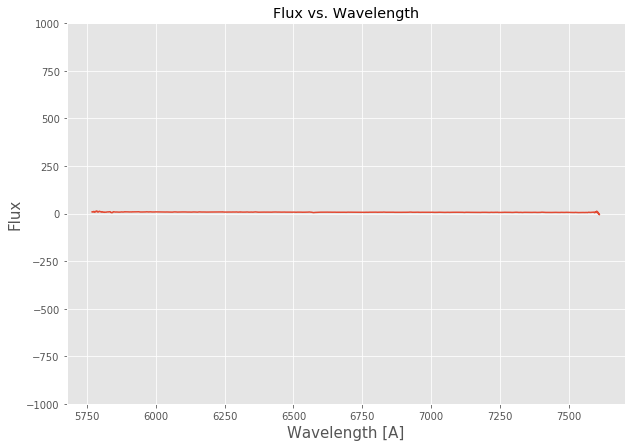

In [24]:
fs = 15
fsize = (10, 7)
padding = 10 #pixels at extremeties excluded from plotting

i = 672
#i = 61085
#i = 62771
plt.figure(figsize=fsize)
plt.plot(starwave[i][padding:-padding], smoothing(starflux[i])[padding:-padding])
plt.title("Flux vs. Wavelength")
plt.xlabel("Wavelength [A]", fontsize = fs)
plt.ylabel("Flux", fontsize = fs)
#plt.ylim(-1000, 1000)

In [29]:
starflux[i][starflux[i] <= 0].size

25

In [153]:
starflux[62771][:-100].mean()

9.534306151553091

In [ ]:
u.AA

In [122]:
from specutils.fitting import fit_generic_continuum
from astropy import units as u
from specutils.spectra import Spectrum1D, SpectralRegion
spectrum = Spectrum1D(flux=starflux[i]*u.Jy, spectral_axis=starwave[i]*u.AA)

In [125]:
gfit = fit_generic_continuum(spectrum)
yfit = gfit(starwave[i]*u.AA)

(-100, 100)

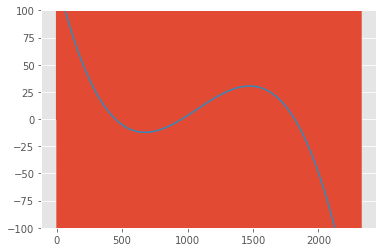

In [129]:
plt.plot(starflux[i])
plt.plot(yfit)
plt.ylim([-100, 100])

In [130]:
spec_normalized = spectrum / yfit

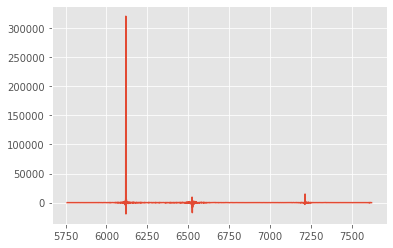

In [131]:
plt.plot(spec_normalized.spectral_axis, spec_normalized.flux)  

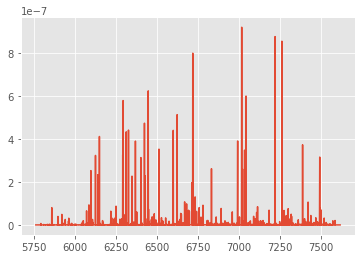

In [105]:
plt.plot(starwave[i], starivar[i])
#plt.xlim([6200, 6300])

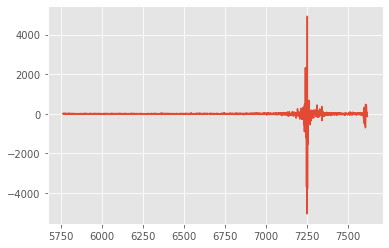

In [117]:
tmpfited, tmpnormed = continuum_normalize(starwave[i], starflux[i], starivar[i])
plt.plot(starwave[i], tmpnormed)
#plt.plot(starwave[i], starflux_normalized[i])
#plt.xlim([6200, 6300])

(6200, 6300)

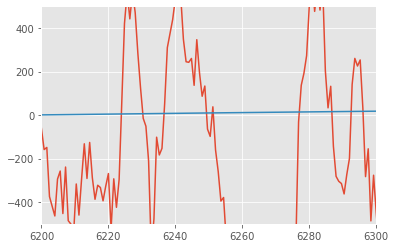

In [107]:
plt.plot(starwave[i], smoothing(starflux[i]))
plt.plot(starwave[i], tmpfited)
plt.ylim([-500, 500])
plt.xlim([6200, 6300])

In [115]:
tmpfited[544]

0.006708549065479019

In [116]:
starflux[i][544]

2425.7138671875

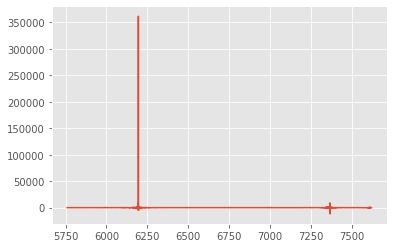

In [110]:
plt.plot(starwave[i], starflux[i]/tmpfited)

In [114]:
starflux_normalized[i][544]

361585.47004892386

In [112]:
starivar[i][544]

1.372269485544475e-11

In [113]:
starivar[i].max()

9.218989021064772e-07

In [111]:
np.where(starflux_normalized[i] == starflux_normalized[i].max())

(array([544]),)

Standard Deviation: 188391321.3576835


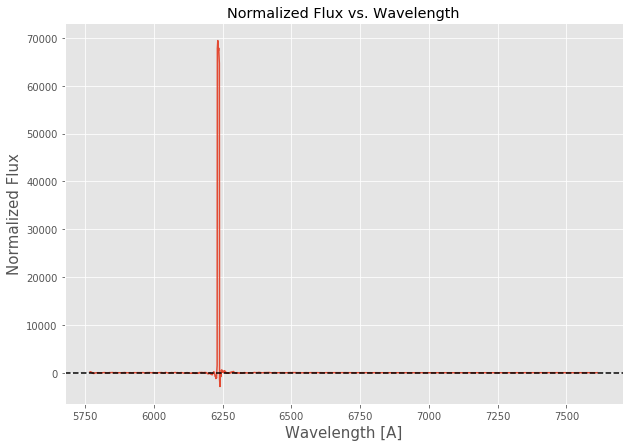

In [57]:
plt.figure(figsize=fsize)
plt.plot(starwave[i][padding:-padding], smoothing(starflux_normalized[i])[padding:-padding])
plt.title("Normalized Flux vs. Wavelength")
plt.xlabel("Wavelength [A]", fontsize = fs)
plt.ylabel("Normalized Flux", fontsize = fs)
plt.axhline(1, c = 'k', ls = '--')
print(f"Standard Deviation: {np.var(starflux_normalized[i])}")

-----
Sanity check
-----
SNR in r-band: 15.220129520897377
Standard Deviation: 12949803370.473572
Standard Deviation from Theory: SNR^2 X Var(flux_normalized) = 15.220129520897377^2 X 55901888.24895941 = 12949803370.473574


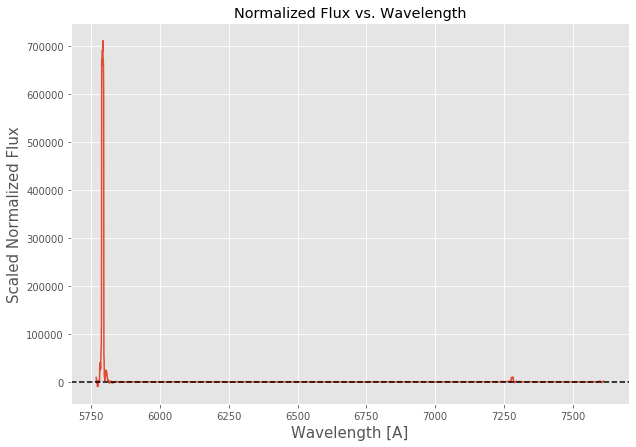

In [52]:
plt.figure(figsize=fsize)
plt.plot(starwave[i][padding:-padding], smoothing(starflux_scaled[i])[padding:-padding])
plt.title("Normalized Flux vs. Wavelength")
plt.xlabel("Wavelength [A]", fontsize = fs)
plt.ylabel("Scaled Normalized Flux", fontsize = fs)
plt.axhline(starsnr_r[i], c = 'k', ls = '--')
print("-----")
print("Sanity check")
print("-----")
print(f"SNR in r-band: {starsnr_r[i]}")
print(f"Standard Deviation: {np.var(starflux_scaled[i])}")
print(f"Standard Deviation from Theory: SNR^2 X Var(flux_normalized) = {starsnr_r[i]}^2 X {np.var(starflux_normalized[i])} = {starsnr_r[i]**2 * np.var(starflux_normalized[i])}")

Standard Deviation of weighted: 12949803370.473566
Standard Deviation of unweighted: 12949803370.473572


(-100, 100)

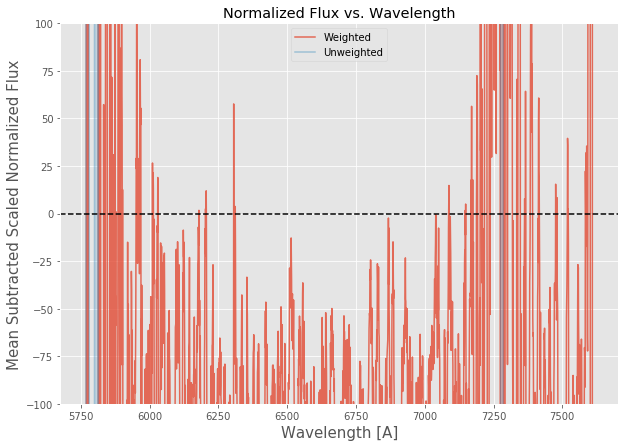

In [53]:
plt.figure(figsize=fsize)
plt.plot(starwave[i][padding:-padding], smoothing(starflux_mean_subtracted_weighted[i])[padding:-padding], label = 'Weighted', alpha = 0.8)
plt.plot(starwave[i][padding:-padding], smoothing(starflux_mean_subtracted_unweighted[i])[padding:-padding], label = 'Unweighted', alpha = 0.4)
plt.title("Normalized Flux vs. Wavelength")
plt.xlabel("Wavelength [A]", fontsize = fs)
plt.ylabel("Mean Subtracted Scaled Normalized Flux", fontsize = fs)
plt.axhline(0, c = 'k', ls = '--')
plt.legend(loc = 'best')
print(f"Standard Deviation of weighted: {np.var(starflux_mean_subtracted_weighted[i])}")
print(f"Standard Deviation of unweighted: {np.var(starflux_mean_subtracted_unweighted[i])}")
plt.ylim([-100, 100])

In [46]:
print(np.mean(starflux_mean_subtracted_weighted[i]))
print(np.mean(starflux_mean_subtracted_unweighted[i]))

10.541652641825303
-9.384296148989802e-15


**Observation**: Normalization, scaling and mean subtraction took place properly.

## Check difference between weighted and unweighted spectra

In [54]:
flag = (starflux_mean_subtracted_weighted.mean(axis = 1) - starflux_mean_subtracted_unweighted.mean(axis = 1)) > 1000
print(starflux_mean_subtracted_weighted[flag].shape)
print(starflux_mean_subtracted_unweighted[flag].shape)

(18, 2326)
(18, 2326)


In [139]:
tmpidx = np.where(flag)[0]

mean: 15.220129520897377
mean: 30.294759400942937
mean: 11.436204884715618
mean: 17.734062954940516
mean: 17.063808579705835
mean: 13.475145723975299
mean: 10.732928082607682
mean: 9.669046173701314
mean: 21.35961371190317
mean: 13.82899076555429
mean: 8.39461634300298
mean: 12.64348839268432
mean: 14.898695467430054
mean: 39.61614591324714
mean: 18.357978217713736
mean: 10.327617773592928
mean: 78.87240507113958
mean: 17.716770211851177


(-10000, 10000)

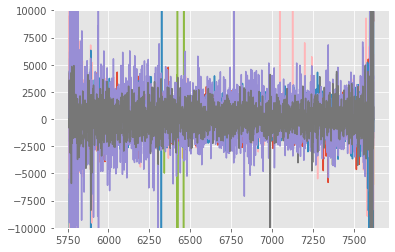

In [150]:
for i in tmpidx:
    plt.plot(starwave[i], starflux[i])
    print(f"mean: {np.median(starsnr_r[i])}")
    
plt.ylim([-10000, 10000])

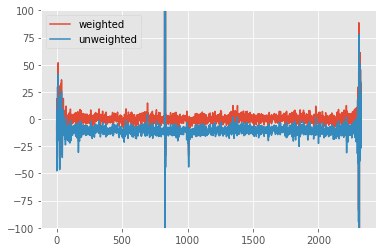

In [40]:
plt.plot(starflux_mean_subtracted_weighted[flag][0], label = 'weighted')
plt.plot(starflux_mean_subtracted_unweighted[flag][0], label = 'unweighted')
plt.ylim([-100, 100])
plt.legend(loc = 'best')

## Visual sanity check for mean subtracted scaled continuum normalized spectra

Plot $10$ random stars and see whether the expected absorption and emission features line up. 

In [22]:
#smooth data
tmpsmoothed_data_weighted = np.zeros(starflux_mean_subtracted_weighted.shape)
tmpsmoothed_data_unweighted = np.zeros(starflux_mean_subtracted_weighted.shape)
for i in range(starflux_mean_subtracted_weighted.shape[0]):
    tmpsmoothed_data_weighted[i] = smoothing(starflux_mean_subtracted_weighted[i])
    tmpsmoothed_data_unweighted[i] = smoothing(starflux_mean_subtracted_unweighted[i])

Text(0.5, 0, 'Wavelength [A]')

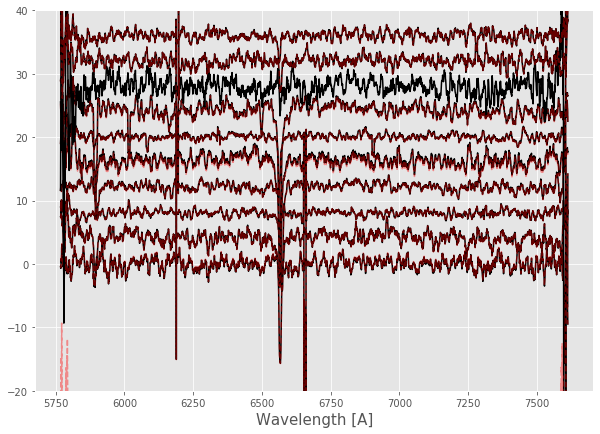

In [25]:
tmp_idx = np.random.choice(starwave.shape[0], size = 10, replace = False)

plt.figure(figsize=fsize)
for i in range(len(tmp_idx)):
    plt.plot(starwave[tmp_idx[i]][padding:-padding], tmpsmoothed_data_weighted[tmp_idx[i]][padding:-padding] + 4*i, c = 'k')
    plt.plot(starwave[tmp_idx[i]][padding:-padding], tmpsmoothed_data_unweighted[tmp_idx[i]][padding:-padding] + 4*i, c = 'r', ls = '--', alpha = 0.4)
plt.ylim([-20, 40])
plt.xlabel("Wavelength [A]", fontsize = fs)

In [125]:
start = time()
cov = starflux_mean_subtracted.T @ starflux_mean_subtracted
tottime = time() - start

print(f"Time took to calculate covariance matrix with data matrix of size {starflux_mean_subtracted.shape}: {tottime} seconds.")

Time took to calculate covariance matrix with data matrix of size (96086, 2326): 8.597388744354248 seconds.


In [126]:
cov

array([[ 2.29312982e+13,  2.30052700e+13,  2.28477148e+13, ...,
         2.29271948e+13,  2.29263572e+13,  2.29257750e+13],
       [ 2.30052700e+13,  7.01248634e+13, -2.17630444e+13, ...,
         2.30727543e+13,  2.29651463e+13,  2.30244166e+13],
       [ 2.28477148e+13, -2.17630444e+13,  6.53702094e+13, ...,
         2.27862109e+13,  2.28860377e+13,  2.28297473e+13],
       ...,
       [ 2.29271948e+13,  2.30727543e+13,  2.27862109e+13, ...,
         2.29784572e+13,  2.29433758e+13,  2.29203956e+13],
       [ 2.29263572e+13,  2.29651463e+13,  2.28860377e+13, ...,
         2.29433758e+13,  2.29467731e+13,  2.29256037e+13],
       [ 2.29257750e+13,  2.30244166e+13,  2.28297473e+13, ...,
         2.29203956e+13,  2.29256037e+13,  2.29373760e+13]])

## Check whether covariance matrix is symmetric

Had precision issue due to flux initially being in `np.float32`. 

In [122]:
counter = 0
bad_i = []; bad_j = [] #store indices of non-symmetric values

for i in range(cov.shape[0]):
    for j in range(cov.shape[1]):
        if((cov[i,j] - cov[j,i]) == 0.00):
            pass
        else:
            counter += 1
            bad_i.append(i)
            bad_j.append(j)

In [123]:
print(f"Total number of elements in the covariance matrix is {cov.shape[0]} X {cov.shape[0]} = {cov.shape[0]**2}.")
print(f"Total number of non-symmetric elements in the covariance matrix is {counter}.")
print(f"Percentage of elements that are non-symmetric: {counter/cov.shape[0]**2 * 100}.")

Total number of elements in the covariance matrix is 2326 X 2326 = 5410276.
Total number of non-symmetric elements in the covariance matrix is 0.
Percentage of elements that are non-symmetric: 0.0.


**Observation:** Covariance matrix is symmetric.

## Check numerical precision of covariance matrix

Let's look at specific elements and calculate dot product manually.

In [109]:
i = 0
j = 1484

covij = 0
covji = 0
for k in range(starflux.shape[0]):
    covij += (starflux_mean_subtracted.T)[i, k] * starflux_mean_subtracted[k, j]
    covji += (starflux_mean_subtracted.T)[j, k] * starflux_mean_subtracted[k, i]

In [110]:
print("From direct calculation")
print(covij)
print(covji)

From direct calculation
22928098446550.324
22928098446550.324


In [111]:
print("From dot product operation")
print(cov[i, j])
print(cov[j, i])

From dot product operation
22928098446550.32
22928098446550.32


In [113]:
print(f"The two values differ by : {np.abs(covij/cov[i, j] - 1) * 100} %.")

The two values differ by : 2.220446049250313e-14 %.


## Check correlation matrix structure

In [114]:
Dinv = np.diag(1 / np.sqrt(np.diag(cov))) 
corr = Dinv @ cov @ Dinv

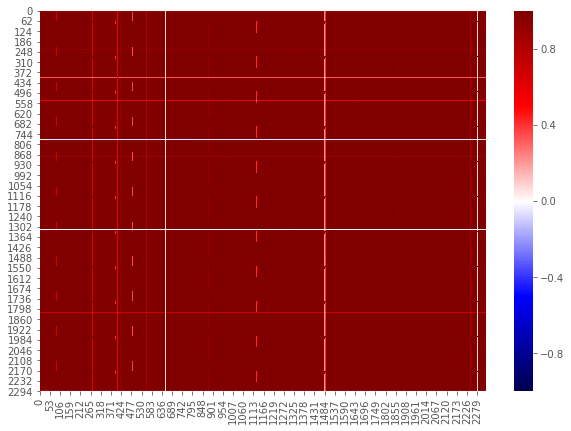

In [115]:
import seaborn as sns
plt.figure(figsize = fsize)
sns.heatmap(corr, cmap = 'seismic')

# Apply `GSPICE` for pixelwise estimation based on the covariance matrix

In [121]:
pred, predvar = pixelwise_estimate(Dvec = starflux_mean_subtracted, cov = cov)

pixelwise_estimate:  npix, nspec= 2326 96086


LinAlgError: Matrix is not positive definite

(-100, 100)

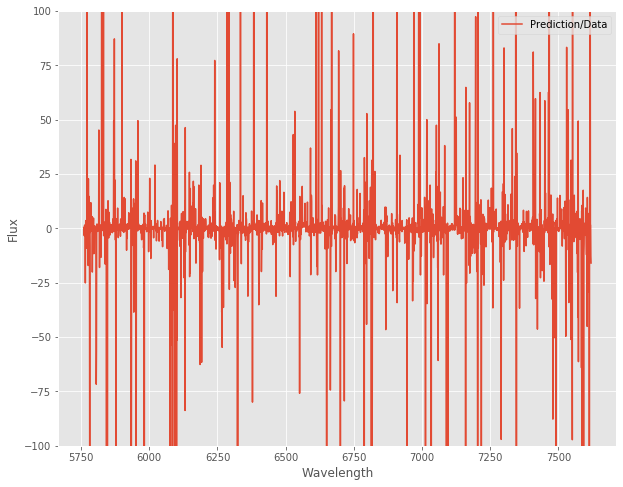

In [23]:
plt.figure(figsize = (10, 8))
i = 15

#for i in range(10):
#plt.plot(starwave[i], starflux[i], label = 'Raw data')
#plt.plot(starwave[i], pred[i], label = 'GSPICE corrected data')
#plt.plot(starwave[i], starflux_preprocessed[i], label = 'Normalized data')
plt.plot(starwave[i], pred[i]/starflux_preprocessed[i], label = 'Prediction/Data')
plt.xlabel("Wavelength")
plt.ylabel("Flux")
plt.legend(loc = 'best')
#plt.xlim([6000, 7500])
plt.ylim([-100, 100])

In [24]:
np.mean(starflux_preprocessed[i])

0.010895483140990689

In [25]:
starflux[i].mean()

40.909392574995834

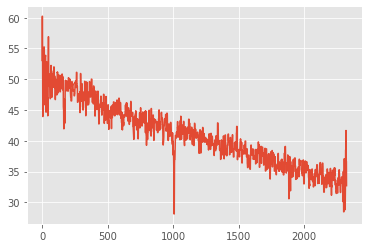

In [26]:
#plt.plot(starflux[i])
plt.plot(medfilt(starflux[i], 5))